### Description
- Patient visits who were transferred within 24 hours
    - ICUs to non-ICUs
    - Non-ICUs to ICUs
- Prediction differences between labels at time 0 and 24hr
- Differences between predicted values at time 0 and time 24 compared to their corresponding true labels
- Within the patient visits who were transferred:
    - More in depth about those with largest differences between the predictions at 2 time points
    - and how they are related to the differences in predicted values vs. true labels
    
Inputs:
- `1_4_cohort`
- prediction outputs for 3 labels using 1_4_cohort with light gbm

Outputs:
- `1_4_cohort_test_results` test cohort (admit year 2019 and 2020) with prediction results
- `1_4_cohort_diff_full_features` 318 observations in test cohort (pred difference >= 0.3) with full features used for predictions

In [3]:
# install.packages('rms')

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘jpeg’, ‘Formula’, ‘latticeExtra’, ‘mvtnorm’, ‘TH.data’, ‘sandwich’, ‘checkmate’, ‘Hmisc’, ‘polspline’, ‘multcomp’, ‘htmlTable’




In [1]:
library(caret) # import this before glmnet to avoid rlang version problem
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
library(glmnet)
library(bit64)
library(pROC)
library(rms)

Loading required package: lattice

Loading required package: ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::lift()      masks caret::lift()
x purrr::transpose() masks data.table::transpose()


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'Matrix'


The following 

In [2]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
modeldir4 = "../../OutputTD/3_models/1_4_cohort"

In [4]:
# list.files(path="modeldir4", pattern="lightgbm_test_results.csv", full.names=TRUE, recursive=FALSE)
# dir(path="modeldir4") #pattern="*.csv")

In [3]:
# check folder and sub-folders
folder <- list.dirs(modeldir4) # this assumes being in the main folder, otherwise specify the path
folder
sub.folders <- folder[-1]  # comment this out if the main folder also contains the script
# script.paths <- paste(folder,"/","process.R", sep="")
# for (i in script.paths) {source(i)}

[1] "../../OutputTD/3_models/1_4_cohort"                        
[2] "../../OutputTD/3_models/1_4_cohort/death_24hr_max_label"   
[3] "../../OutputTD/3_models/1_4_cohort/death_24hr_recent_label"
[4] "../../OutputTD/3_models/1_4_cohort/first_label"

In [4]:
# sub-folders
sub.folders <- list.dirs(modeldir4)[-1]
sub.folders

[1] "../../OutputTD/3_models/1_4_cohort/death_24hr_max_label"   
[2] "../../OutputTD/3_models/1_4_cohort/death_24hr_recent_label"
[3] "../../OutputTD/3_models/1_4_cohort/first_label"

In [5]:
cohort <- read.csv(file.path(cohortdir, '1_4_cohort.csv'))
nrow(cohort)
colnames(cohort)

[1] 43980

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"

### Patient visits year and those who transferred

In [6]:
cohort_test <-  cohort %>% mutate(admit_time = ymd_hms(admit_time)) %>% 
                    mutate(adm_year = year(admit_time),
                           transfer = ifelse(death_24hr_recent_label != first_label, 1, 0)) %>% 
                    filter(adm_year > 2018)
nrow(cohort_test)
table(cohort_test$adm_year)
sum(cohort_test$transfer)

[1] 12418


 2019  2020 
10115  2303 

[1] 805

In [7]:
summary(cohort$death_24hr_recent_label)
summary(cohort_test$death_24hr_recent_label)
summary(cohort_test$acute_to_critical_label_recent)
summary(cohort_test$critical_to_acute_label_recent)

sum(cohort_test$critical_to_acute_label_recent) #526 + 279 = 805 total transfers
sum(cohort_test$acute_to_critical_label_recent)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.09468 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.104   0.000   1.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02247 0.00000 1.00000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.04236 0.00000 1.00000 

[1] 526

[1] 279

### Patient visits with big differences in predictions at 2 time points

In [8]:
for (f in sub.folders){
    print(f)
    out <- read.csv(paste0(f,"/","lightgbm_test_results.csv")) %>% select(pat_enc_csn_id_coded, predictions)
    cohort_test <- cohort_test %>% inner_join(out)
#     cohort_test[ , ncol(cohort_test) + 1] <- out$predictions
#     newcolname <- paste0("pred_", str_sub(f, start=-12))
    newcolname <- paste0("pred_", str_sub(f, start=36, end=-7))
    print(newcolname)
#     cohort_test <- cohort_test %>% rename(newcolname = predictions)
#     print(colnames(cohort_test))
    colnames(cohort_test)[ncol(cohort_test)] <- newcolname
}

[1] "../../OutputTD/3_models/1_4_cohort/death_24hr_max_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_death_24hr_max"
[1] "../../OutputTD/3_models/1_4_cohort/death_24hr_recent_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_death_24hr_recent"
[1] "../../OutputTD/3_models/1_4_cohort/first_label"


Joining, by = "pat_enc_csn_id_coded"



[1] "pred_first"


In [9]:
pred3 <- gather(cohort_test, labels, predictions, pred_death_24hr_max:pred_first, factor_key=TRUE)
pred2 <- pred3 %>% filter(labels != 'pred_death_24hr_max')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



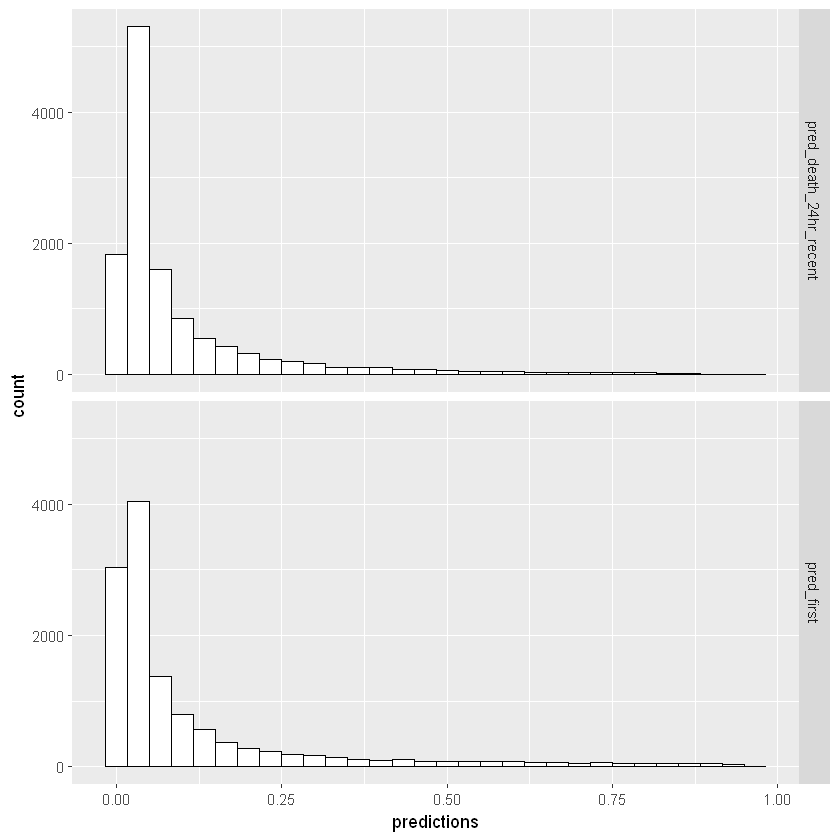

In [10]:
ggplot(pred2, aes(x = predictions)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(labels ~ .)

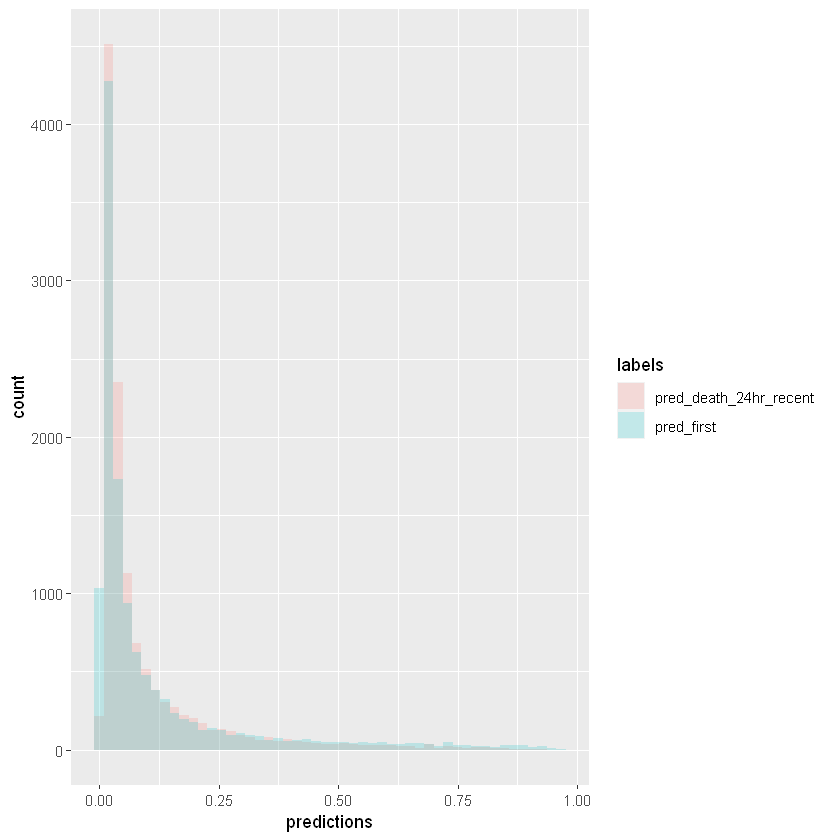

In [11]:
ggplot(pred2, aes(x = predictions, fill = labels)) +         
  geom_histogram(position = "identity", alpha = 0.2, bins = 50)

In [12]:
cohort_test <- cohort_test %>% mutate(diff0_24 = round(pred_first - pred_death_24hr_recent, 2),
                                      diff0_True = round(pred_first - first_label, 2),
                                      diff24_True = round(pred_death_24hr_recent - death_24hr_max_label, 2)) %>%
               mutate(abs_diff0_24 = round(abs(diff0_24), 1))

In [13]:
nrow(cohort_test)
colnames(cohort_test)
summary(cohort_test)

[1] 12418

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "transfer"                        "pred_death_24hr_max"            
[21] "pred_death_24hr_recent"          "pred_first"                     
[23] "diff0_24"                        "diff0_True"                     
[25] "diff24_True"                     "abs_diff0_24"

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:12418       Min.   :1.313e+11    Min.   :33212811       
 Class :character   1st Qu.:1.313e+11    1st Qu.:35996148       
 Mode  :character   Median :1.313e+11    Median :39994636       
                    Mean   :1.313e+11    Mean   :40003546       
                    3rd Qu.:1.313e+11    3rd Qu.:43886508       
                    Max.   :1.313e+11    Max.   :48026130       
                                                                
   admit_time                   label_max24     label_24hr_recent
 Min.   :2019-01-01 00:03:00   Min.   :0.0000   Min.   :0.0000   
 1st Qu.:2019-04-13 00:01:30   1st Qu.:0.0000   1st Qu.:0.0000   
 Median :2019-08-04 21:50:30   Median :0.0000   Median :0.0000   
 Mean   :2019-08-08 00:19:00   Mean   :0.1512   Mean   :0.1033   
 3rd Qu.:2019-12-01 06:24:15   3rd Qu.:0.0000   3rd Qu.:0.0000   
 Max.   :2020-03-31 07:00:00   Max.   :1.0000   Max.   :1.0000   
                  

5%   10%   20%   30%   40%   50%   60%   70%   80%   90%   95% 
-0.05 -0.03 -0.01 -0.01  0.00  0.00  0.00  0.01  0.03  0.10  0.18

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.42000 -0.01000  0.00000  0.01798  0.02000  0.73000 

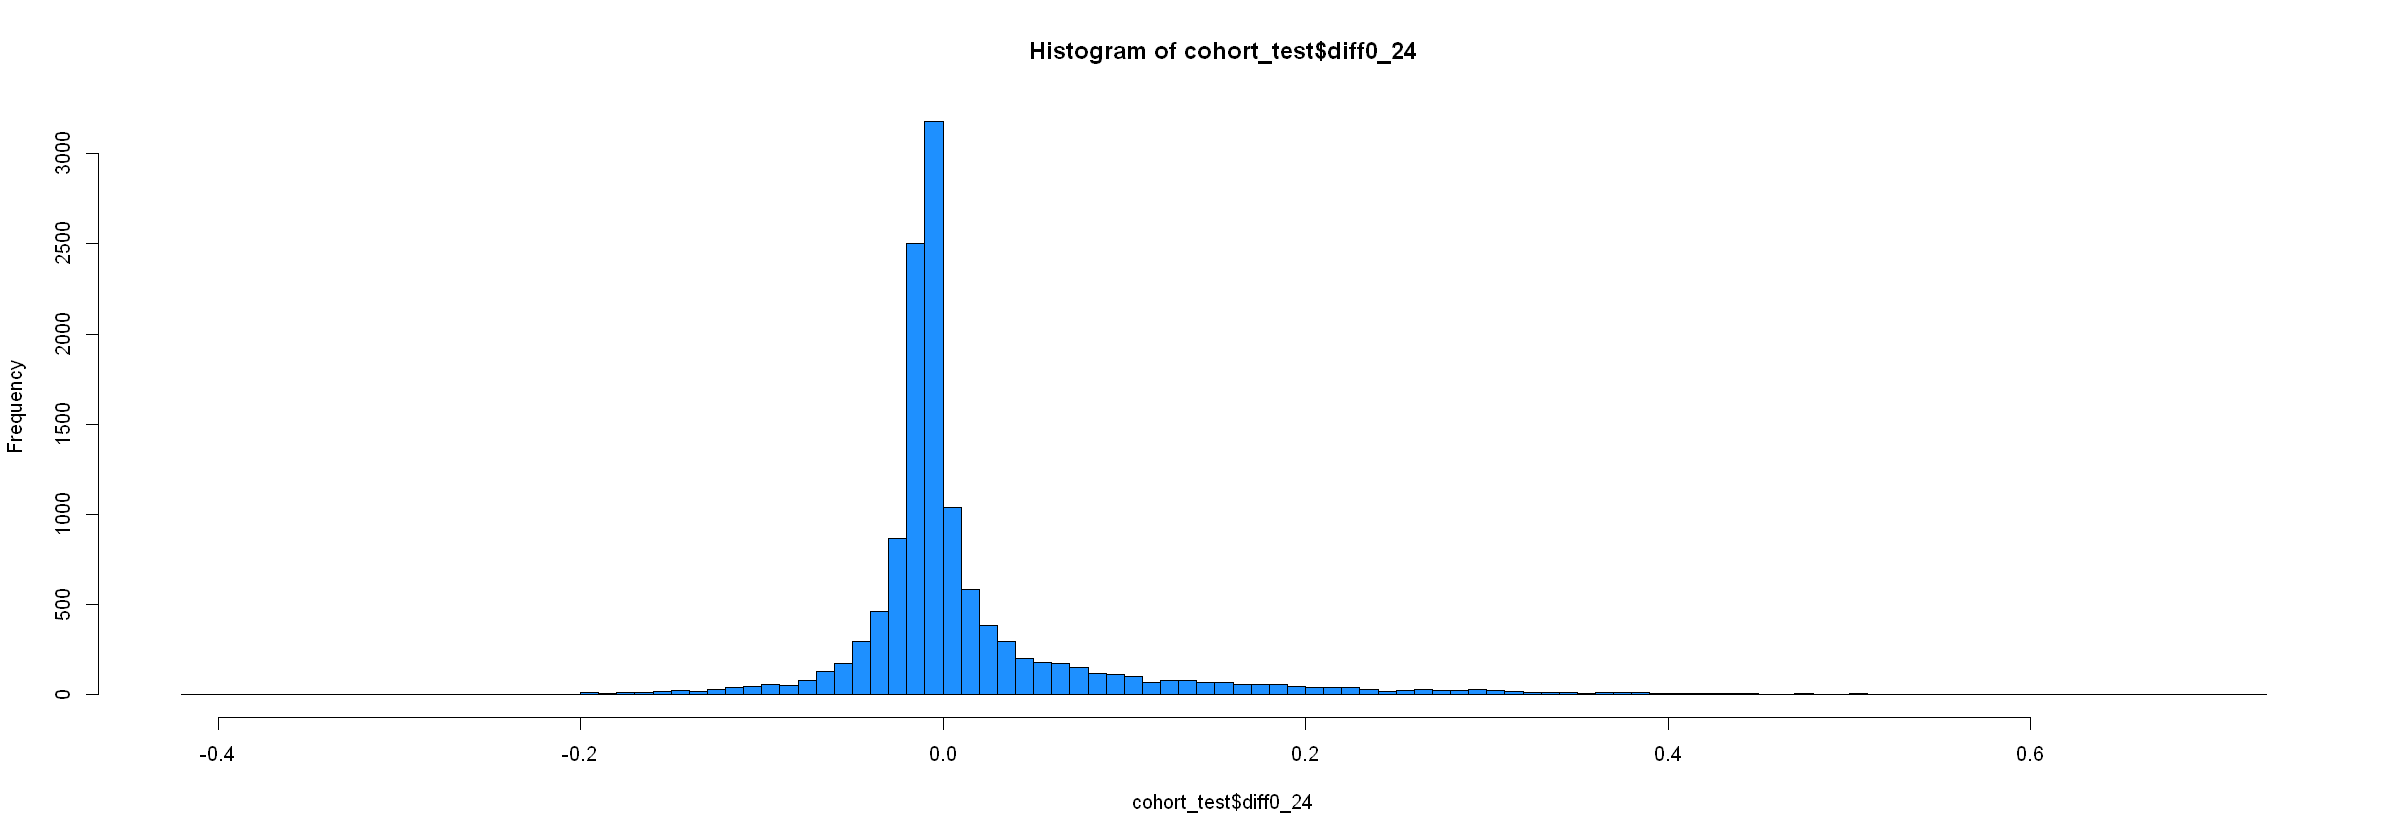

In [14]:
options(repr.plot.width=20, repr.plot.height=7)

quantile(cohort_test$diff0_24, c(.05, .1, .2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95)) 
summary(cohort_test$diff0_24)
hist(cohort_test$diff0_24, col='dodgerblue', breaks=100)

In [15]:
# diff <- cohort_test %>% arrange(-abs_diff0_24) %>% 
#         mutate(rec = 1, pround = round(abs_diff0_24, 1)) %>% 
#         group_by(pround) %>% mutate(psum = sum(rec)) %>% 
#         distinct(pround, psum) %>%
#         filter(pround > 0) #%>% mutate(cumsize = cumsum(psum)) # %>% select(-rec)

# diff$cumsize <- cumsum(diff$psum)

nrow(cohort_test %>% filter(abs_diff0_24 >= 0.3))
diff <- cohort_test %>% 
            group_by(abs_diff0_24) %>% summarise(count = n()) %>% arrange(-abs_diff0_24) %>% 
            mutate(cum_count = cumsum(count), cumperc = round(100*cum_count/nrow(cohort_test), 2)) 

diff

[1] 318

`summarise()` ungrouping output (override with `.groups` argument)



abs_diff0_24,count,cum_count,cumperc
<dbl>,<int>,<int>,<dbl>
0.7,3,3,0.02
0.6,8,11,0.09
0.5,22,33,0.27
0.4,79,112,0.90
0.3,206,318,2.56
0.2,501,819,6.60
0.1,1619,2438,19.63
0.0,9980,12418,100.00


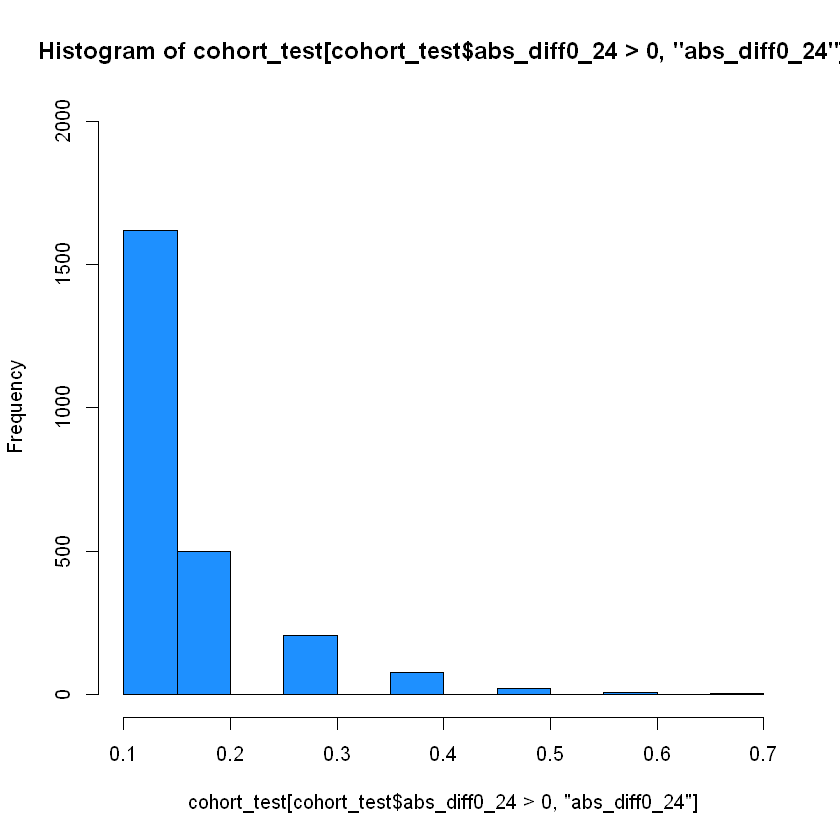

In [16]:
# threshold and size plot
options(repr.plot.width=7, repr.plot.height=7)

# absolute count
hist(cohort_test[cohort_test$abs_diff0_24 > 0, 'abs_diff0_24'], col='dodgerblue', ylim=c(0, 2000))

In [17]:
diff[diff$abs_diff0_24 > 0.1,]$cum_count

[1]   3  11  33 112 318 819

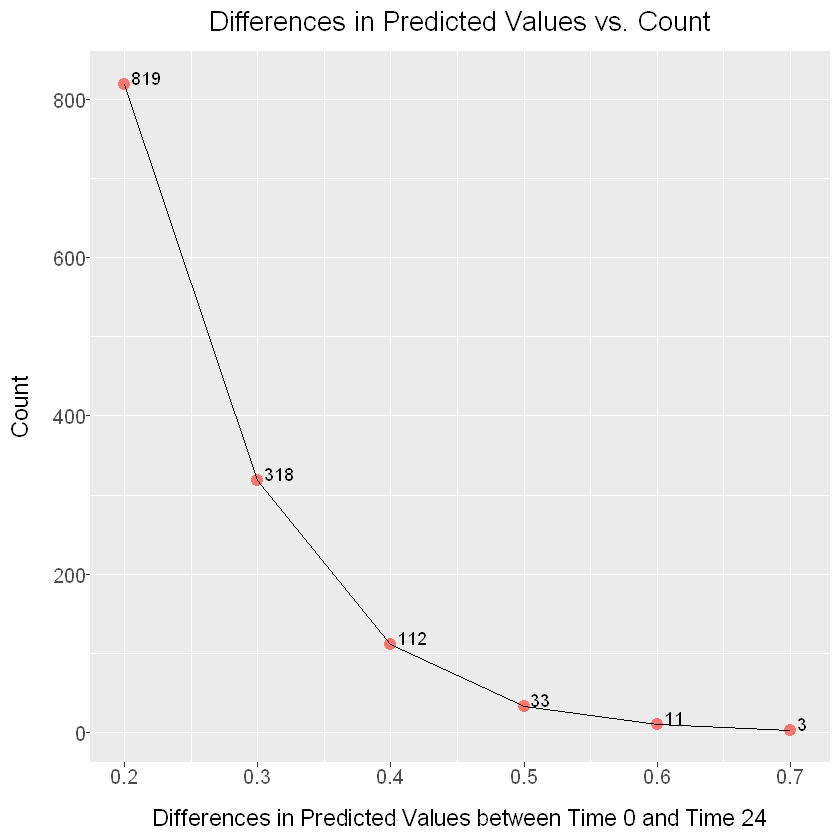

In [18]:
# cummulative count
ggplot(diff[diff$abs_diff0_24 > 0.1, ], aes(x=abs_diff0_24, y=cum_count)) + 
    geom_point(color = "#F8766D", size = 3) + geom_line() +
    geom_text(label=diff[diff$abs_diff0_24 > 0.1, ]$cum_count, hjust = 0, nudge_x = 0.005, vjust =0) + 
    labs(x="Differences in Predicted Values between Time 0 and Time 24", y="Count", 
               title = "Differences in Predicted Values vs. Count") +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)), #color = "red", 
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)), #color = "red",
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14),
          legend.key.size = unit(1, "cm"))#, face="bold"
# ggsave("Figure - Count of Differences.png", width = 14, height = 7, dpi = 1200) 

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



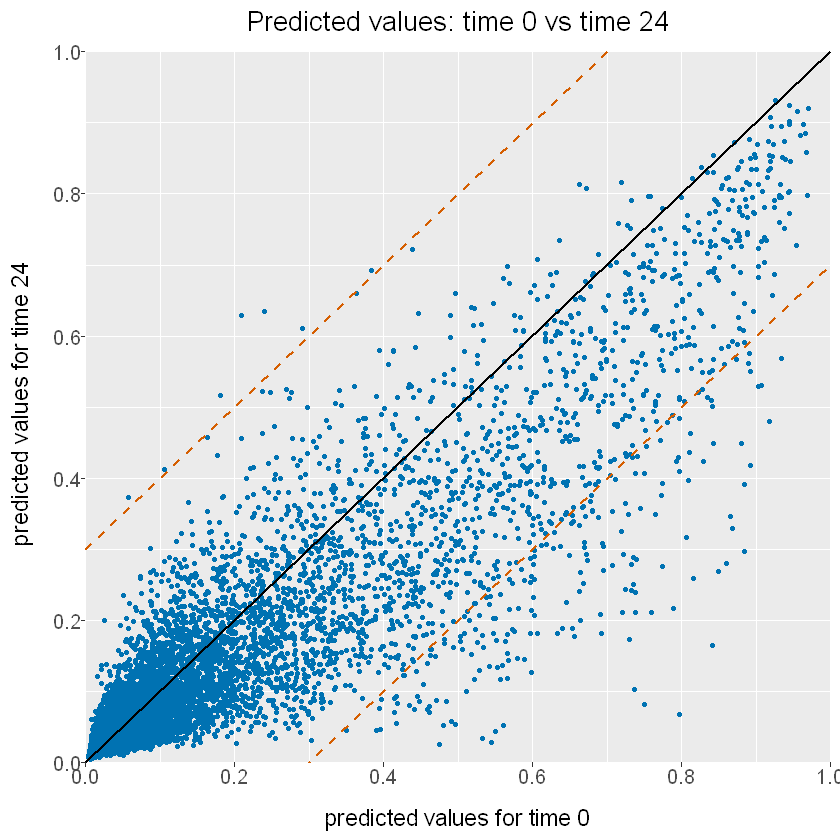

In [19]:
options(repr.plot.width=7, repr.plot.height=7)

ggplot(cohort_test, aes(x=pred_first, y=pred_death_24hr_recent)) + 
    geom_point(color = "#0072B2", size = 1) + xlim(0,1) + ylim(0,1) +
    geom_abline(intercept = 0, slope = 1, size = 0.7) +
    geom_abline(intercept = 0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    geom_abline(intercept = -0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    scale_x_continuous(name = "predicted values for time 0", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) + 
    scale_y_continuous(name = " predicted values for time 24", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)),
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)),
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14)) +
     labs(title = "Predicted values: time 0 vs time 24")


In [20]:
write.csv(cohort_test, file.path(modeldir4, "1_4_cohort_test_results.csv"), row.names=FALSE)

### Get all features used for prediction for the test cohort

In [8]:
orders5 <- read.csv(file.path(datadir, 'coh5_order_code_counts.csv'))
nrow(orders5) # should have 5730678

[1] 5730678

In [63]:
orders4 <- read.csv(file.path(datadir, 'coh4_order_code_counts.csv')) %>% 
            mutate(admit_time = ymd_hms(admit_time),
                   feature_type = ifelse(str_detect(feature_type, "Microbiology"), "Microbiology", feature_type))
nrow(orders4) # 4322665 is in correct, should have 6086852

[1] 6086852

In [65]:
values <- read.csv(file.path(featuredir, '2_7_coh4_feature_values.csv')) %>% mutate(admit_time = ymd_hms(admit_time))
nrow(values) #3085046

[1] 3085046

In [66]:
colnames(orders4)
colnames(values)
colnames(cohort_test)
nrow(cohort_test)

[1] "anon_id"              "pat_enc_csn_id_coded" "admit_time"          
[4] "feature_type"         "features"             "values"

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "feature_type"            "features"               
 [9] "values"                  "time"

[1] "anon_id"                         "pat_enc_csn_id_coded"           
 [3] "inpatient_data_id_coded"         "admit_time"                     
 [5] "label_max24"                     "label_24hr_recent"              
 [7] "admit_label"                     "has_admit_label"                
 [9] "died_within_24hrs"               "death_24hr_max_label"           
[11] "death_24hr_recent_label"         "first_label"                    
[13] "first_label_minutes_since_admit" "acute_to_critical_label_recent" 
[15] "critical_to_acute_label_recent"  "acute_to_critical_label_max"    
[17] "critical_to_acute_label_max"     "adm_year"                       
[19] "transfer"                        "pred_death_24hr_max"            
[21] "pred_death_24hr_recent"          "pred_first"                     
[23] "diff0_24"                        "diff0_True"                     
[25] "diff24_True"                     "abs_diff0_24"

[1] 12418

In [67]:
cohort_diff <- cohort_test %>% select(anon_id, pat_enc_csn_id_coded, admit_time, 
                                      first_label, death_24hr_recent_label, death_24hr_max_label,
                                      pred_first, pred_death_24hr_recent, abs_diff0_24, diff0_True, diff24_True) %>% 
                    filter(abs_diff0_24 >= 0.3)

In [68]:
diff_cohort_orders <- left_join(cohort_diff, orders4)
diff_cohort_values <- left_join(cohort_diff, values) 
length(unique(diff_cohort_orders$pat_enc_csn_id_coded))
length(unique(diff_cohort_values$pat_enc_csn_id_coded))

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "first_label", "death_24hr_recent_label", "death_24hr_max_label")



[1] 318

[1] 318

In [69]:
nrow(diff_cohort_orders)
nrow(diff_cohort_values)
diff_cohort_orders %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)
diff_cohort_values %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

[1] 40709

[1] 30398

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Microbiology,203
Procedures,513
Imaging,1822
Lab,6305
Meds,12397
Diagnosis,19469


`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
demo,5406
vitals,12376
labs,12616


In [70]:
diff_cohort_full_features <- full_join(diff_cohort_orders, diff_cohort_values)
nrow(diff_cohort_full_features)
nrow(diff_cohort_orders) + nrow(diff_cohort_values)
length(unique(diff_cohort_full_features$pat_enc_csn_id_coded))
diff_cohort_full_features %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "admit_time", "first_label", "death_24hr_recent_label", "death_24hr_max_label", "pred_first", "pred_death_24hr_recent", "abs_diff0_24", "diff0_True", "diff24_True", "feature_type", "features", "values")



[1] 71107

[1] 71107

[1] 318

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Microbiology,203
Procedures,513
Imaging,1822
demo,5406
Lab,6305
vitals,12376
Meds,12397
labs,12616
Diagnosis,19469


In [71]:
write.csv(diff_cohort_full_features, file.path(modeldir4, "1_4_cohort_diff_full_features.csv"), row.names=FALSE)

### Patient visits predictions vs. truth


In [72]:
summary(cohort_test$diff0_True)
summary(cohort_test$diff24_True)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.990000  0.010000  0.030000 -0.007673  0.070000  0.930000 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.99000  0.01000  0.03000 -0.05359  0.06000  0.76000 

In [73]:
diff3 <- gather(cohort_test, diffs, values, diff0_24:diff24_True, factor_key=TRUE)
diff2 <- diff3 %>% filter(diffs != 'diff0_24')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



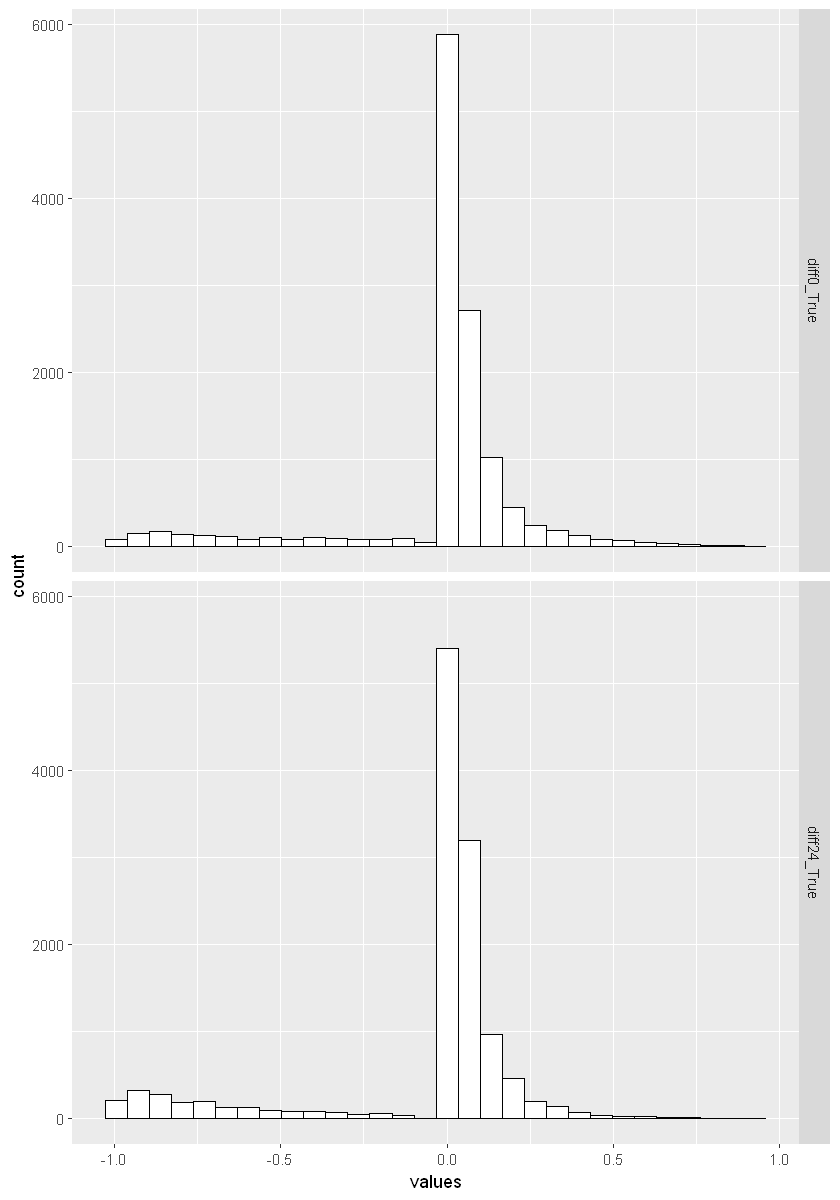

In [74]:
options(repr.plot.width=7, repr.plot.height=10)

ggplot(diff2, aes(x = values)) +
  geom_histogram(fill = "white", colour = "black") +
  facet_grid(diffs ~ .)

### 

### Check most difference first
- 0.7 or more: 3
- 0.6 or more: 11
- 0.5 or more: 33

In [75]:
diff

abs_diff0_24,count,cum_count,cumperc
<dbl>,<int>,<int>,<dbl>
0.7,3,3,0.02
0.6,8,11,0.09
0.5,22,33,0.27
0.4,79,112,0.90
0.3,206,318,2.56
0.2,501,819,6.60
0.1,1619,2438,19.63
0.0,9980,12418,100.00


### Check AUC and PRC

[1] 0.8759954

[1] 0.6425512

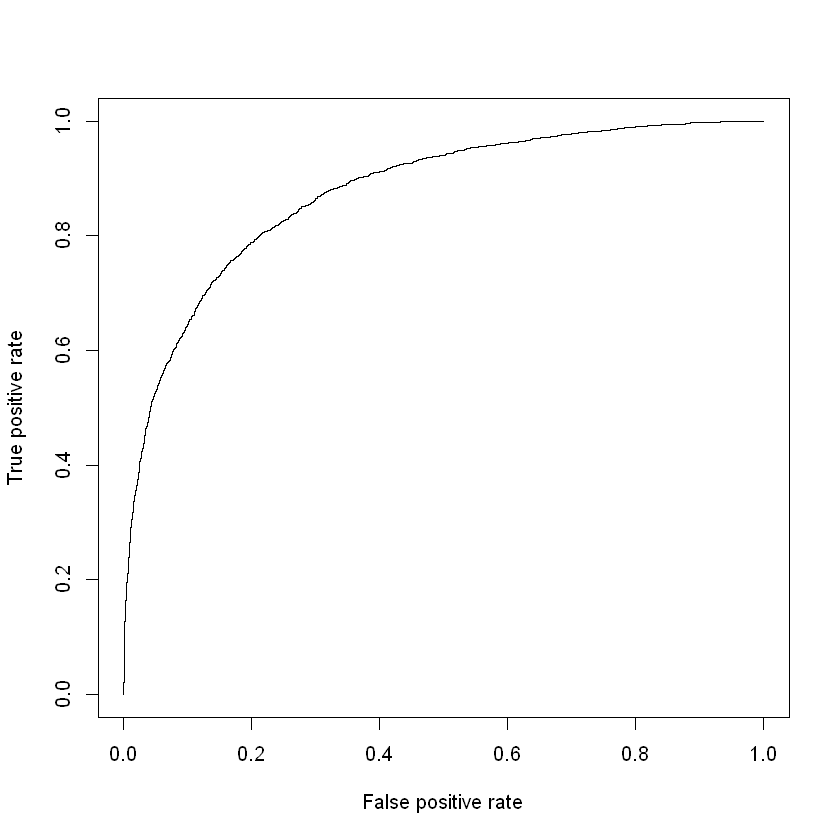

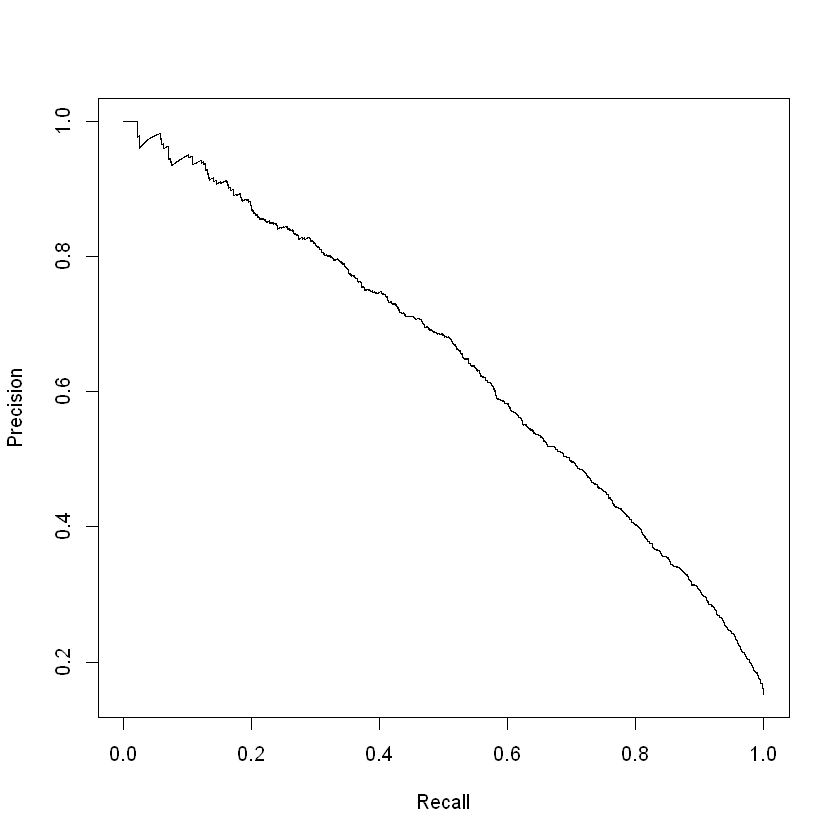

In [74]:
# get performance metrics AUC and PRC, highest level of care
options(repr.plot.width=7, repr.plot.height=7)

# pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_recent, cohort_test$death_24hr_recent_label)
pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_max, cohort_test$death_24hr_max_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)

[1] 0.8527461

[1] 0.4911128

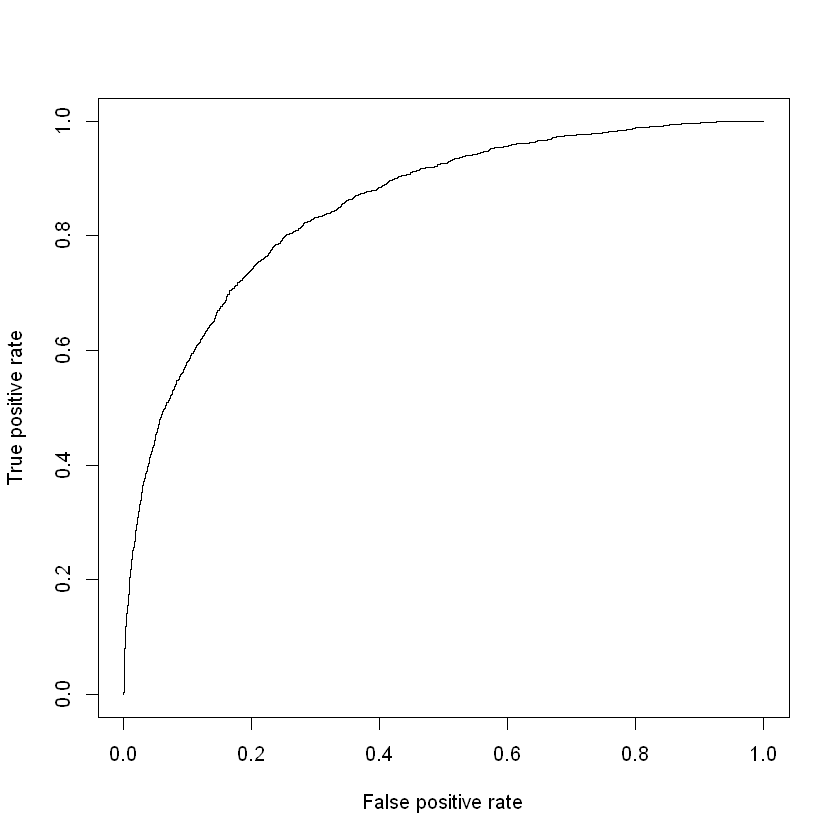

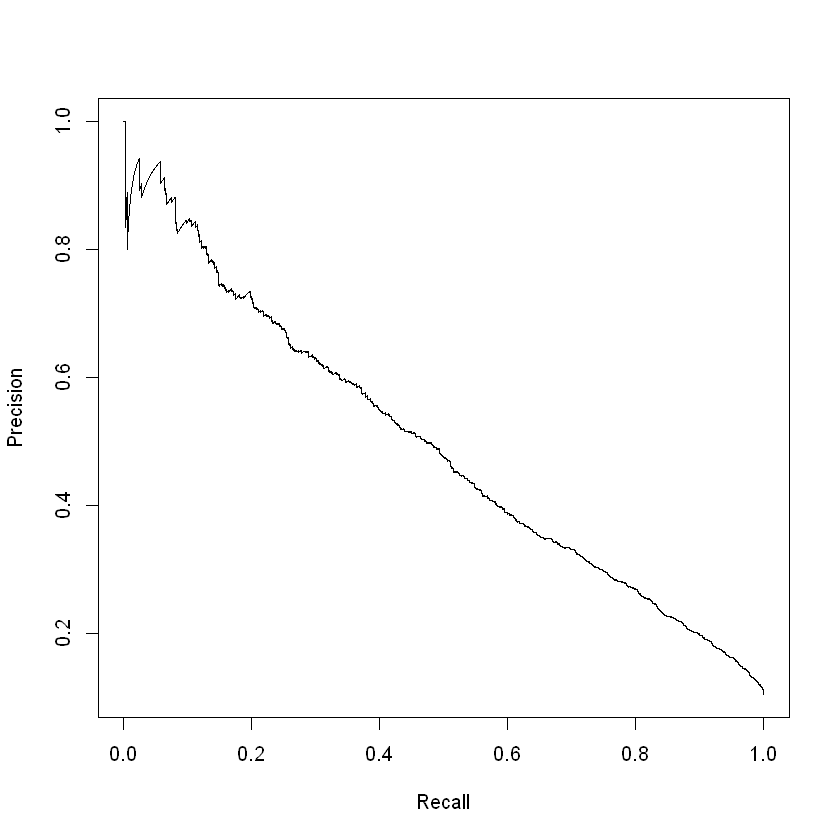

In [70]:
# get performance metrics AUC and PRC, at 24hr
options(repr.plot.width=7, repr.plot.height=7)

pred_rocr = ROCR::prediction(cohort_test$pred_death_24hr_recent, cohort_test$death_24hr_recent_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)

[1] 0.8513965

[1] 0.487724

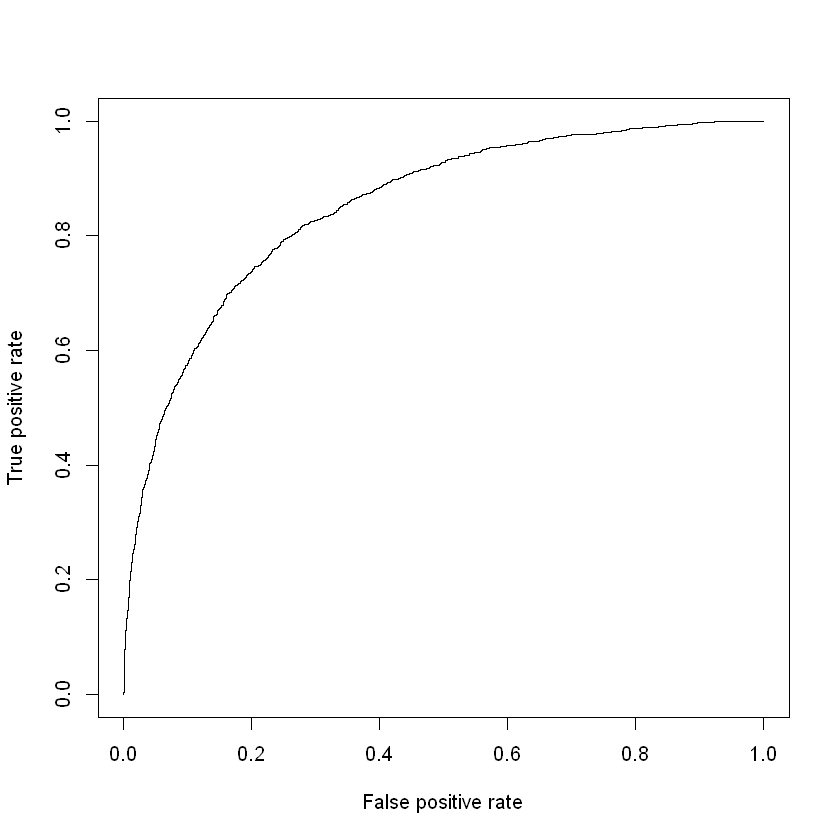

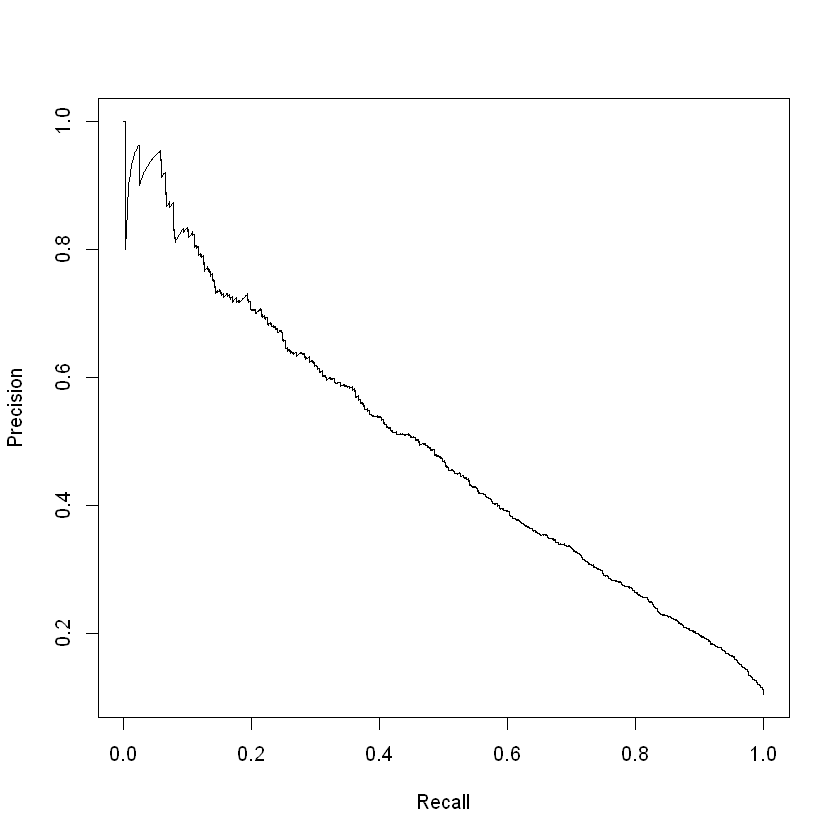

In [73]:
test2019 <- cohort_test %>% filter(adm_year==2019)
pred_rocr = ROCR::prediction(test2019$pred_death_24hr_recent, test2019$death_24hr_recent_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)

[1] 0.9072535

[1] 0.6422387

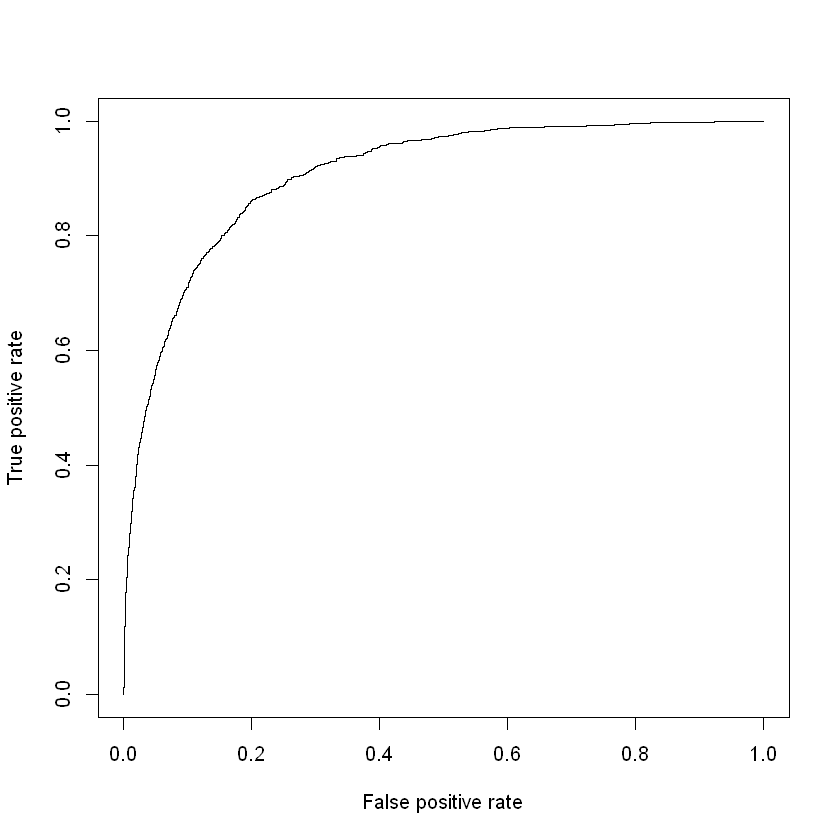

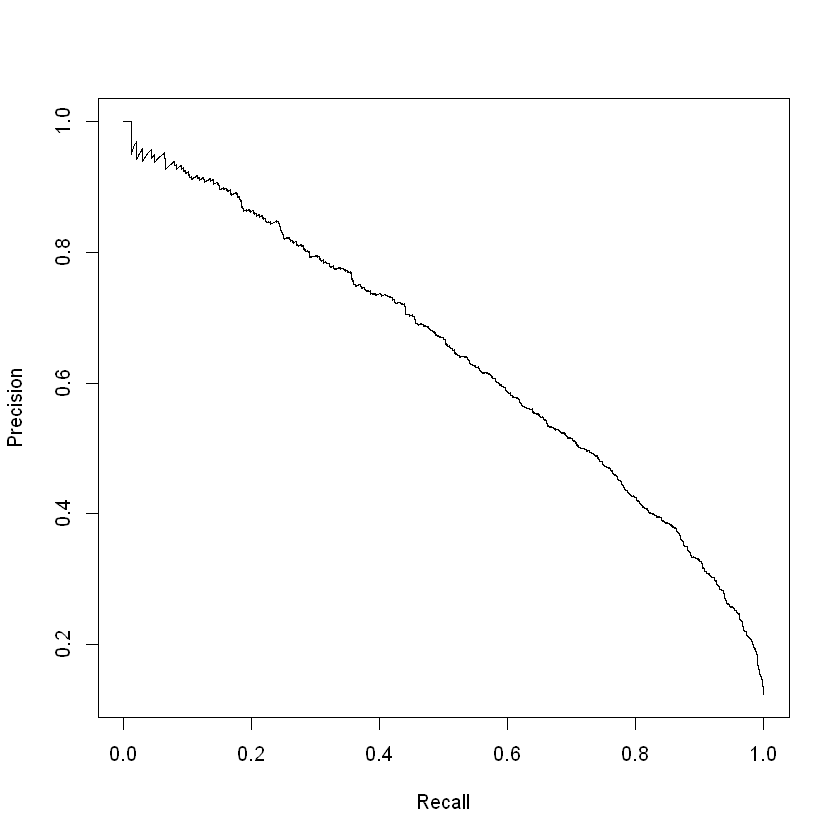

In [76]:
# get performance metrics AUC and PRC, and ACC
options(repr.plot.width=7, repr.plot.height=7)

pred_rocr = ROCR::prediction(cohort_test$pred_first, cohort_test$first_label)
auc = ROCR::performance(pred_rocr, measure = "auc", x.measure = "cutoff")@y.values[[1]]
prc = ROCR::performance(pred_rocr, measure = "aucpr", x.measure = "cutoff")@y.values[[1]]

PRC.perf <- ROCR::performance(pred_rocr, "prec", "rec")
ROC.perf <-  ROCR::performance(pred_rocr, "tpr", "fpr")
auc; prc

plot(ROC.perf)
plot(PRC.perf)